In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import re
from util import resolve_path

In [5]:
# import sys
# import sklearn.neighbors._base
# sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
# # Link: https://github.com/epsilon-machine/missingpy/issues/38#issuecomment-1614864022
# from missingpy import MissForest

In [2]:
from lifelines import CoxPHFitter
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import GridSearchCV, KFold
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import set_config

In [3]:
%matplotlib inline

In [4]:
set_config(display='text')  # displays text representation of estimators

### data set overview

In [4]:
rows_GBM = pd.read_pickle('./results/only_GBM_dx_dates.pkl')
rows_GBM

,Date_of_death,Date_of_Diagnosis,Age_at_Time_of_Diagnosis
Subject,,,
1799-Subject-00000017,NaT,1997-12-01,48
1799-Subject-00000025,2011-03-13,2003-10-29,50
1799-Subject-00000544,NaT,2004-02-01,11
1799-Subject-00000028,2005-08-27,2004-06-09,35
1799-Subject-00000029,2007-08-21,2004-07-30,35
...,...,...,...
1799-Subject-00001604,NaT,2021-10-19,71
1799-Subject-00001606,NaT,2021-11-09,53
1799-Subject-00001608,NaT,2021-11-17,61


In [5]:
med_hist = pd.read_pickle('./results/explanatory_drugs.pkl')
med_hist

,Order_Name=$$$10582,Order_Name=$$$1094833,Order_Name=$$$1098414,Order_Name=$$$1597876,Order_Name=$$$1790172,Order_Name=$$$1868004,Order_Name=$$$2178390,Order_Name=$$$253337,Order_Name=$$$315699,Order_Name=$$$315700,...,Order_Name=provigil,Order_Name=relatlimab,Order_Name=rindopepimut compassionate injection 500 mcg / 0.5 ml,Order_Name=rindopepimut compassionate injection 500 mcg rindopepimut and 150 mcg sargramostim / 0.8 ml,Order_Name=rindopepimut intradermal compassionate use,Order_Name=saline nasal rinse kit,Order_Name=saliva substitute solution,Order_Name=skin test read order,Order_Name=xenaderm,Order_Name=zometa zoledronic acid infusion
Subject,,,,,,,,,,,,,,,,,,,,,
1799-Subject-00000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1799-Subject-00000012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1799-Subject-00000015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1799-Subject-00000017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1799-Subject-00000021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799-Subject-00001554,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1799-Subject-00001562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1799-Subject-00001567,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
med_hist.iloc[0,1:592]

Order_Name=$$$1094833                         0.0
Order_Name=$$$1098414                         0.0
Order_Name=$$$1597876                         0.0
Order_Name=$$$1790172                         0.0
Order_Name=$$$1868004                         0.0
                                             ... 
Order_Name=saline nasal rinse kit             0.0
Order_Name=saliva substitute solution         0.0
Order_Name=skin test read order               0.0
Order_Name=xenaderm                           0.0
Order_Name=zometa zoledronic acid infusion    0.0
Name: 1799-Subject-00000003, Length: 591, dtype: float64

In [6]:
demo_info = pd.read_pickle('./results/explanatory_demo.pkl')
demo_info

,Gender,Race,Ethnicity
Subject,,,
1799-Subject-00000001,Male,White,Not Hispanic or Latino
1799-Subject-00000002,Male,White,Not Hispanic or Latino
1799-Subject-00000003,Female,White,Not Hispanic or Latino
1799-Subject-00000007,Male,White,Not Hispanic or Latino
1799-Subject-00000008,Female,White,Not Hispanic or Latino
...,...,...,...
1799-Subject-00001562,Male,White,Not Hispanic or Latino
1799-Subject-00001567,Female,White,Not Hispanic or Latino
1799-Subject-00001573,Female,White,Not Hispanic or Latino


In [27]:
demo_info = demo_info.dropna()
demo_info.shape

(1110, 3)

In [36]:
nan_df = demo_info[demo_info.isna().any(axis=1)]
nan_df

,Gender,Race,Ethnicity
Subject,,,
1799-Subject-00000140,Male,NaN,Not Hispanic or Latino
1799-Subject-00000194,Female,NaN,Hispanic or Latino
1799-Subject-00000309,Female,White,NaN
1799-Subject-00000312,Male,NaN,Hispanic or Latino
1799-Subject-00000313,Female,White,NaN
1799-Subject-00000314,Male,White,NaN
1799-Subject-00000320,Male,White,NaN
1799-Subject-00000321,Female,White,NaN
1799-Subject-00000337,Female,White,NaN


In [32]:
med_hist.index.intersection(rows_GBM.index).intersection(demo_info.index).shape

(402,)

In [33]:
rows_GBM.loc[med_hist.index.intersection(rows_GBM.index).intersection(demo_info.index)]

,Date_of_death,Date_of_Diagnosis,Age_at_Time_of_Diagnosis
Subject,,,
1799-Subject-00000003,2008-08-31,2007-02-02,60
1799-Subject-00000012,2015-09-07,2014-08-07,52
1799-Subject-00000015,2008-03-26,2007-11-16,49
1799-Subject-00000017,NaT,1997-12-01,48
1799-Subject-00000021,2014-09-07,2008-02-07,41
...,...,...,...
1799-Subject-00001554,2020-09-21,2020-09-01,72
1799-Subject-00001562,2020-12-29,2020-10-09,25
1799-Subject-00001567,NaT,2020-11-17,65


In [13]:
common_index = med_hist.index.intersection(rows_GBM.index).intersection(demo_info.index)
common_index.shape

(389,)

In [14]:
rows_GBM = rows_GBM.loc[common_index]
med_hist = med_hist.loc[common_index]
demo_info = demo_info.loc[common_index]

In [15]:
demo_info_t = OneHotEncoder().fit_transform(X=demo_info)
demo_info_t

,Gender=Male,Race=Black/African Amer,Race=Hawaiian/Pac. Island,Race=Multiple Race,Race=White,Race=Am Indian/Alaska Nat,Ethnicity=Not Hispanic or Latino
Subject,,,,,,,
1799-Subject-00000003,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1799-Subject-00000012,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1799-Subject-00000015,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1799-Subject-00000017,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1799-Subject-00000021,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...
1799-Subject-00001554,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1799-Subject-00001562,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1799-Subject-00001567,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [16]:
data_x = pd.concat([med_hist, demo_info_t], axis='columns', join='outer')
data_x

,Order_Name=$$$10582,Order_Name=$$$1094833,Order_Name=$$$1098414,Order_Name=$$$1597876,Order_Name=$$$1790172,Order_Name=$$$1868004,Order_Name=$$$2178390,Order_Name=$$$253337,Order_Name=$$$315699,Order_Name=$$$315700,...,Order_Name=skin test read order,Order_Name=xenaderm,Order_Name=zometa zoledronic acid infusion,Gender=Male,Race=Black/African Amer,Race=Hawaiian/Pac. Island,Race=Multiple Race,Race=White,Race=Am Indian/Alaska Nat,Ethnicity=Not Hispanic or Latino
Subject,,,,,,,,,,,,,,,,,,,,,
1799-Subject-00000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1799-Subject-00000012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1799-Subject-00000015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1799-Subject-00000017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1799-Subject-00000021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799-Subject-00001554,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1799-Subject-00001562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1799-Subject-00001567,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [18]:
rows_GBM['Status'] = pd.isna(rows_GBM['Date_of_death'])

In [19]:
END_DX_DATE = pd.to_datetime('2022/01/13')  # Confirmed by BTRIS

In [20]:
rows_GBM['Date_of_death'] = rows_GBM['Date_of_death'].fillna(END_DX_DATE)

In [21]:
rows_GBM['Survival_in_days'] = (rows_GBM['Date_of_death'] - \
        rows_GBM['Date_of_Diagnosis']).dt.days

In [24]:
rows_GBM
#[['Status', 'Survival_in_days']]

,Date_of_death,Date_of_Diagnosis,Age_at_Time_of_Diagnosis,Status,Survival_in_days
Subject,,,,,
1799-Subject-00000003,2008-08-31,2007-02-02,60,False,576
1799-Subject-00000012,2015-09-07,2014-08-07,52,False,396
1799-Subject-00000015,2008-03-26,2007-11-16,49,False,131
1799-Subject-00000017,2022-01-13,1997-12-01,48,True,8809
1799-Subject-00000021,2014-09-07,2008-02-07,41,False,2404
...,...,...,...,...,...
1799-Subject-00001554,2020-09-21,2020-09-01,72,False,20
1799-Subject-00001562,2020-12-29,2020-10-09,25,False,81
1799-Subject-00001567,2022-01-13,2020-11-17,65,True,422


'''Citation: Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.'''

In [15]:
# TK (rewrite) to incorporate one-hot encoding
def format_4_assumption_tests(filepath_dx: str='./results/only_GBM_dx_dates.pkl',
                              filepath_meds: str='./results/explanatory_drugs.pkl',
                              filepath_demo: str='./results/explanatory_demo.pkl',
                              filepath_labs: str='./results/explanatory_labs.pkl'):
    '''Condense TK and format explanatory and response variable inputs for assumption testing.'''

    print('Formatting data in preparation for assumption diagnostics...')

    # Resolve the relative paths
    #filepath_dx, filepath_meds, filepath_demo, filepath_labs = resolve_path('../intermediates/only_GBM_dx_dates.pkl'), resolve_path('../intermediates/explanatory_drugs.pkl'), resolve_path('../intermediates/explanatory_demo.pkl'), resolve_path('../intermediates/explanatory_labs.pkl')

    # Load and deserialize diagnoses DataFrame
    rows_GBM = pd.read_pickle(filepath_dx)

    # Load and deserialize drugs DataFrame
    med_hist = pd.read_pickle(filepath_meds)

    # Load and deserialize demographics DataFrame
    demo_info = pd.read_pickle(filepath_demo)

    # Load and deserialize laboratory tests DataFrame
    # lab_data = pd.read_pickle(filepath_labs)

    '''Method 1: Simply removing missing demographic information'''
    demo_info = demo_info.dropna()
    # TK fill in lab_data stuff

    # Set-intersect indices to get common patients between drugs and diagnostic datasets
    common_med_dx_index = med_hist.index.intersection(rows_GBM.index)

    # Set-intersect indices again to get common patients between all three of drugs, diagnostic, and demographic dataseta
    common_index = common_med_dx_index.intersection(demo_info.index)
    print(f'Potential Subjects:\t{len(common_med_dx_index)}\t\tActual Subjects:\t{len(common_index)}')

    # Filter out non-intersected rows
    rows_GBM = rows_GBM.loc[common_index]
    med_hist = med_hist.loc[common_index]
    demo_info = demo_info.loc[common_index]

    # Filter out features not satisfying the rule of 10

    # One-hot encode all the categorical variables
    demo_info_t = OneHotEncoder().fit_transform(X=demo_info)

    # Concatenate encoded DataFrames into explanatory DataFrame
    data_x = pd.concat([med_hist, demo_info_t], axis='columns', join='outer')

    # TK add a filter here filtering out the columns without at least 10% observations/patients

    # The patients with no (i.e. missing) death-date by end-data-collection date are right-censored (`Status == False`)
    rows_GBM['Status'] = pd.isna(rows_GBM['Date_of_death'])
    n_censored, n_unique = rows_GBM['Status'].sum(), rows_GBM['Status'].shape[0]
    with open('./results/n_right_censored.txt', 'w') as file:
        line = f'Right-censored: {n_censored}\tTotal: {n_unique}\tPercent right-censored: {n_censored / n_unique * 100:.2f}%'
        print(line)
        file.write(line)
    '''Link: "Five-year relative survival was lowest for glioblastoma (6.8%)" (PMID: 31675094)'''

    END_DX_DATE = pd.to_datetime('2022/01/13')  # Confirmed by BTRIS
    # Fill NAs in `Date_of_death` column with the end-data-collection date to get a survival duration anyways
    rows_GBM['Date_of_death'] = rows_GBM['Date_of_death'].fillna(END_DX_DATE)

    # Calculate duration between (1st) GBM diagnosis date and death/end-data-collection date
    rows_GBM['Survival_in_days'] = (rows_GBM['Date_of_death'] - \
        rows_GBM['Date_of_Diagnosis']).dt.days

    print('Formatting data in preparation for assumption diagnostics done.')

    print(data_x.head(7))
    print(data_x.info())

    return [data_x, rows_GBM[['Status', 'Survival_in_days']]]


In [ ]:
# SX (combine) to incorporate two steps into one
def pre_4_Suv_analysis(filepath_dx: str='./results/only_GBM_dx_dates.pkl',
                              filepath_meds: str='./results/explanatory_drugs.pkl',
                              filepath_demo: str='./results/explanatory_demo.pkl'):

    print('Preparing data in preparation for survival analysis...')

    
    # Load and deserialize diagnoses DataFrame
    rows_GBM = pd.read_pickle(filepath_dx)

    # Load and deserialize drugs DataFrame
    med_hist = pd.read_pickle(filepath_meds)

    # Load and deserialize demographics DataFrame
    demo_info = pd.read_pickle(filepath_demo)


    # 'Method 1: Simply removing missing demographic information'''
     demo_info = demo_info.dropna()  # have to keep this line
    

    # Set-intersect indices to get common patients between drugs and diagnostic datasets
    common_med_dx_index = med_hist.index.intersection(rows_GBM.index)

    # Set-intersect indices again to get common patients between all three of drugs, diagnostic, and demographic dataseta
    common_index = common_med_dx_index.intersection(demo_info.index)
    print(f'Potential Subjects:\t{len(common_med_dx_index)}\t\tActual Subjects:\t{len(common_index)}')

    # Filter out non-intersected rows
    rows_GBM = rows_GBM.loc[common_index]
    med_hist = med_hist.loc[common_index]
    demo_info = demo_info.loc[common_index]

    # Filter out features not satisfying the rule of 10

    # One-hot encode all the categorical variables
    demo_info_t = OneHotEncoder().fit_transform(X=demo_info)

    # Concatenate encoded DataFrames into explanatory DataFrame
    data_x = pd.concat([med_hist, demo_info_t], axis='columns', join='outer')

    # TK add a filter here filtering out the columns without at least 10% observations/patients

    # The patients with no (i.e. missing) death-date by end-data-collection date are right-censored (`Status == False`)
    rows_GBM['Status'] = pd.isna(rows_GBM['Date_of_death'])
    n_censored, n_unique = rows_GBM['Status'].sum(), rows_GBM['Status'].shape[0]
    with open('./results/n_right_censored.txt', 'w') as file:
        line = f'Right-censored: {n_censored}\tTotal: {n_unique}\tPercent right-censored: {n_censored / n_unique * 100:.2f}%'
        print(line)
        file.write(line)
    '''Link: "Five-year relative survival was lowest for glioblastoma (6.8%)" (PMID: 31675094)'''

    END_DX_DATE = pd.to_datetime('2022/01/13')  # Confirmed by BTRIS
    # Fill NAs in `Date_of_death` column with the end-data-collection date to get a survival duration anyways
    rows_GBM['Date_of_death'] = rows_GBM['Date_of_death'].fillna(END_DX_DATE)

    # Calculate duration between (1st) GBM diagnosis date and death/end-data-collection date
    rows_GBM['Survival_in_days'] = (rows_GBM['Date_of_death'] - \
        rows_GBM['Date_of_Diagnosis']).dt.days

    print('Formatting data in preparation for assumption diagnostics done.')

    print(data_x.head(7))
    print(data_x.info())

    return [data_x, rows_GBM[['Status', 'Survival_in_days']]]


#### *1. can these NaN be considered right-censored? how they are treated in next steps?
#### *2. check how the med_hist and med value calcuated
#### *3. why got different results?

In [105]:
#df = format_4_assumption_tests()
df[1]

,Status,Survival_in_days
Subject,,
1799-Subject-00000003,False,576
1799-Subject-00000012,False,396
1799-Subject-00000015,False,131
1799-Subject-00000017,True,8809
1799-Subject-00000021,False,2404
...,...,...
1799-Subject-00001554,False,20
1799-Subject-00001562,False,81
1799-Subject-00001567,True,422


In [6]:
def format_4_surv_analysis(data_x: pd.DataFrame, rows_GBM: pd.DataFrame):
    '''Convert the dependent variables into a structured array with [`Status`, `Survival_in_days`] as fields. TK i converted this too early (TK did i?) (assumption diagnostics work better with un-converted DataFrames than structured arrays)'''
    dtypes = np.dtype([('Status', '?'), ('Survival_in_days', '<f8')])
    data_y = np.array([tuple(value) for value in rows_GBM.values],
                      dtype=dtypes)
    # data_xt = data_xt.astype(float)

    return [data_x, data_y]


In [108]:
df1 = format_4_surv_analysis(df,rows_GBM)

ValueError: could not assign tuple of length 3 to structure with 2 fields.

In [7]:
def recover_drug_name_else_return(maybe_rxcui: str) -> str:
    with open('./results/after_&_before_normalization.json', 'r') as file:
        try:
            maybe_drug_name = json.load(file)[maybe_rxcui.replace('Order_Name=', '')].replace('$$$', '').capitalize()
            return maybe_drug_name
        except KeyError:
            return maybe_rxcui

In [21]:
def save_coefficients_vs_alpha_plot(data_x: pd.DataFrame,
                                    data_y: pd.DataFrame,
                                    # filepath_y: str = '../data_y.pkl',
                                    # filepath_x: str='../data_x.pkl',
                                    n_highlight: int=7):
    '''Perform preliminary survival analysis (i.e. to get an idea of the most important features). Exits pipeline because it's not modifying the data nor generating any results. From: https://scikit-survival.readthedocs.io/en/stable/user_guide/coxnet.html#Penalized-Cox-Models'''

    # Load and deserialize data
    # data_x, data_y = pd.read_pickle(resolve_path(filepath_x)), pd.read_pickle(resolve_path(filepath_y))

    '''Weigh l1 (i.e. LASSO) penalty at 90%. Set alpha to be decreased until 1% of its original value (where feature coefficients are all zero).'''
    print('Fitting (preliminary) to Cox PH model...')
    cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
    cox_elastic_net.fit(data_x, data_y)

    coefficients_elastic_net = pd.DataFrame(
        cox_elastic_net.coef_, index=data_x.columns,
        columns=np.round(cox_elastic_net.alphas_, 5)
    )
    print('Fitting (preliminary) to Cox PH model done.')

    # Elastic-Net-penalized Cox Proportional Hazard Model
    '''Use this because we have many features, and we want to select the most influential'''
    def plot_coefficients(coefs, n_highlight):
        _, ax = plt.subplots(figsize=(9, 5))
        alphas = coefs.columns
        for row in coefs.itertuples():
            ax.semilogx(alphas, row[1:], '.-', label=row.Index)

        # Labels will be at left-end of graph
        alpha_min = alphas.min()
        # Get the top (wrt abs value) coefficients
        top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)

        # Labeling the graphs of the top coefficients
        for feature_name in top_coefs.index:
            coef = coefs.loc[feature_name, alpha_min]
            # Check whether the order had been marked
            marked_4_interest = feature_name.startswith('$$$')
            line_label = recover_drug_name_else_return(feature_name).replace(
                '$$$', '').split(' ')[0]
            plt.text(alpha_min, coef, ('$$$ ' if marked_4_interest else '') + (line_label if line_label != '' else feature_name) + '        ',
                horizontalalignment='right', verticalalignment='center')

        ax.set_title('Feature coefficients over a range of possible penalty strengths')
        ax.yaxis.set_label_position('right')
        ax.yaxis.tick_right()
        ax.grid(True)
        ax.set_title('Coefficients of features for various values of penalty strength')
        ax.set_xlabel('penalty strength $\\alpha$')
        ax.set_ylabel('Coefficient')
        plt.savefig('./plots/coefs_over_alphas_t2.png')
        plt.show()

    plot_coefficients(coefficients_elastic_net, n_highlight)


In [18]:
ALPHA_MIN_RATIO = 0.01  # Lowest successful percentage of alpha (2 s.f.)
def choose_penalty_strength(data_x: pd.DataFrame,
                            data_y:  pd.DataFrame,
                            alpha_min_ratio: float=ALPHA_MIN_RATIO):
    '''Choose a penalty strength, and with it, the features. Exits pipe to avoid repeating expensive gridsearches. From: https://scikit-survival.readthedocs.io/en/stable/user_guide/coxnet.html#Choosing-penalty-strength-alpha'''

    print('Choosing penalty strength via cross-validation...')

    # Load and deserialize data
    # data_x, data_y = pd.read_pickle(resolve_path(filepath_x)), pd.read_pickle(resolve_path(filepath_y))

    '''Max iterations can be lower since we are only interested in alphas, not coefficients.'''
    coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=alpha_min_ratio, max_iter=100))
    warnings.simplefilter('ignore', UserWarning)
    warnings.simplefilter('ignore', FitFailedWarning)
    coxnet_pipe.fit(data_x, data_y)

    '''5-fold cross-validation estimating concordance for each estimated alpha'''
    estimated_alphas = coxnet_pipe.named_steps['coxnetsurvivalanalysis'].alphas_
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    gcv = GridSearchCV(
        make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
        param_grid={'coxnetsurvivalanalysis__alphas': [[v] for v in estimated_alphas]},
        cv=cv,
        error_score=0.5,
        n_jobs=1,
    ).fit(data_x, data_y)

    print(gcv.cv_results_)

    # Serialize results and visualization information
    pd.DataFrame(gcv.cv_results_).to_pickle('./results/cv_results.pkl')
    with open('./results/best_params.json', 'w', encoding='ascii') as file:
        json.dump(gcv.best_params_, file, ensure_ascii=False, indent=4)
    best_model = gcv.best_estimator_.named_steps['coxnetsurvivalanalysis']
    pd.DataFrame(best_model.coef_, index=data_x.columns, columns=['coefficient']).to_pickle('./results/best_coefs.t2.pkl')

    print('Choosing penalty strength via cross-validation done.')



In [19]:
def save_concord_idx_vs_alphas_plot(filepath_cv_results: str='./results/cv_results.pkl'):
    '''Visualize cross-validation results. Exits pipeline because it's not modifying the data nor results. From: https://scikit-survival.readthedocs.io/en/stable/user_guide/coxnet.html#Choosing-penalty-strength-$$\alpha$$'''

    print('Generating concordance vs. alphas plot...')

    cv_results = pd.read_pickle(filepath_cv_results)
    with open('./results/best_params.json', 'r') as file:
        best_alpha = json.loads(file.read())['coxnetsurvivalanalysis__alphas'][0]
    alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
    mean = cv_results.mean_test_score
    std = cv_results.std_test_score
    _, ax = plt.subplots(figsize=(9, 6))
    ax.plot(alphas, mean)
    ax.set_title('Mean concordance index over a range of penalty strengths (with best strength indicated)')
    ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
    ax.set_xscale('log')
    ax.set_ylabel('Concordance index')
    ax.set_xlabel('penalty strength $\\alpha$')
    best_mean = mean[alphas[alphas == best_alpha].index[0]]
    # Label the vertical line
    ax.axvline(best_alpha, color='C1')
    ax.text(x=best_alpha, y=0.383, s=f'$\\alpha$={best_alpha:.2f}', horizontalalignment='center', verticalalignment='top')
    # Label the horizontal line
    ax.axhline(best_mean, color='dimgrey')
    ax.text(x=0.001, y=best_mean, s=f'{best_mean:.2f}  ', verticalalignment='center', horizontalalignment='right')
    ax.axhline(0.5, color='grey', linestyle='--')
    ax.grid(True)
    plt.savefig('./plots/concord_idx_over_alphas.t2.png')

    print('Generating concordance vs. alphas plot done.')


In [11]:
def save_features_and_coeffs_plot(filepath_best_coefs: str ='./results/best_coefs.pkl',
                                  n_shown: int = 20):
    '''From: https://scikit-survival.readthedocs.io/en/stable/user_guide/coxnet.html#Choosing-penalty-strength-alpha'''

    print('Generating features and coefficients plot...')

    best_coefs = pd.read_pickle(filepath_best_coefs)
    non_zero = (best_coefs.iloc[:, 0] != 0).sum()
    print(f'Number of non-zero coefficients: {non_zero}')

    non_zero_coefs = best_coefs.query('coefficient != 0').copy()

    print(non_zero_coefs.index)
    print(non_zero_coefs['coefficient'])

    # TK temporary measure to get drugs with more observations than less
    # larger_drugs_indices = non_zero_coefs.index.isin(mask_filtering_out_small_drugs())
    # non_zero_coefs = non_zero_coefs.loc[larger_drugs_indices]

    non_zero_coefs['feature_names'] = ''
    for feature_rxcui in non_zero_coefs.index:
        marked_4_interest = feature_rxcui.startswith('$$$')
        name = recover_drug_name_else_return(feature_rxcui).replace('$$$', '').split(' ')[0]
        non_zero_coefs.loc[feature_rxcui, 'feature_names'] = ('$$$' if marked_4_interest else '') + name if name != '' else feature_rxcui

    coef_order = non_zero_coefs['coefficient'].sort_values(ascending=True).index  # TK THIS is what to sort

    _, ax = plt.subplots(figsize=(10, 8))
    ordered_coefs = non_zero_coefs.loc[coef_order]
    ordered_coefs = ordered_coefs.reset_index().set_index('feature_names')
    ordered_coefs.plot.barh(ax=ax, legend=False)
    # TK Note ascending=False when sorting earlier, and iloc[::-1] when selecting rows, in the line above
    ax.set_title('Features and their coefficients, sorted by coeff.')
    ax.set_ylabel('Feature')
    ax.set_xlabel('coefficient')
    ax.grid(True, axis='x')
    plt.tight_layout()
    plt.savefig('./plots/features_and_coefs.png')

    print('Generating features and coefficients plot done.')


In [12]:
def save_prognosis_plot_for_specific_feature(level: str,
                                             filepath_best_params: str='./results/best_params.json',
                                             filepath_x: str='data_x.pkl',
                                             filepath_y: str='data_y.pkl'):
    '''From: https://scikit-survival.readthedocs.io/en/stable/user_guide/coxnet.html#Survival-and-Cumulative-Hazard-Function'''

    print('Generating prognosis plot for specific feature...')

    best_params = json.loads(filepath_best_params)
    data_x = pd.read_pickle(filepath_x)
    data_y = pd.read_pickle(filepath_y)

    coxnet_pred = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True))
    coxnet_pred.set_params(**best_params)
    coxnet_pred.fit(data_x, data_y)

    surv_fns = coxnet_pred.predict_survival_function(data_x)

    time_points = np.quantile(data_y['t.tdm'], np.linspace(0, 0.6, 100))
    legend_handles = []
    legend_labels = []
    _, ax = plt.subplots(figsize=(9, 6))
    for fn, label in zip(surv_fns, data_x.loc[:, level].astype(int)):
        (line,) = ax.step(time_points, fn(time_points), where='post', color=f'C{label}', alpha=0.5)
        if legend_handles.shape[0] <= label:
            name = 'positive' if label == 1 else 'negative'
            legend_labels.append(name)
            legend_handles.append(line)

    ax.set_title(f'Survival probability vs. Time, for level {str(level)}')
    ax.legend(legend_handles, legend_labels)
    ax.set_xlabel('time (days)')
    ax.set_ylabel('Survival probability')
    ax.grid(True)

    plt.savefig(f'./plots/prog_for_level_{str(level)}.png')

    print('Generating prognosis plot for specific feature done.')


In [ ]:
# save_coefficients_vs_alpha_plot(*format_4_surv_analysis(*format_4_assumption_tests()))
# choose_penalty_strength(*format_4_surv_analysis(*format_4_assumption_tests()))
save_concord_idx_vs_alphas_plot()
save_features_and_coeffs_plot()
#save_prognosis_plot_for_specific_feature(level='')

In [22]:
save_coefficients_vs_alpha_plot(*format_4_surv_analysis(*format_4_assumption_tests()))

Formatting data in preparation for assumption diagnostics...
Potential Subjects:	402		Actual Subjects:	402
Right-censored: 45	Total: 402	Percent right-censored: 11.19%
Formatting data in preparation for assumption diagnostics done.
                       Order_Name=$$$10582  Order_Name=$$$1094833  \
Subject                                                             
1799-Subject-00000003                  0.0                    0.0   
1799-Subject-00000012                  0.0                    0.0   
1799-Subject-00000015                  0.0                    0.0   
1799-Subject-00000017                  0.0                    0.0   
1799-Subject-00000021                  0.0                    0.0   
1799-Subject-00000025                  0.0                    0.0   
1799-Subject-00000028                  0.0                    0.0   

                       Order_Name=$$$1098414  Order_Name=$$$1597876  \
Subject                                                               
1799

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


ValueError: Input X contains NaN.
CoxnetSurvivalAnalysis does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
choose_penalty_strength(*format_4_surv_analysis(*format_4_assumption_tests()))

Formatting data in preparation for assumption diagnostics...
Potential Subjects:	402		Actual Subjects:	389
Right-censored: 41	Total: 389	Percent right-censored: 10.54%
Formatting data in preparation for assumption diagnostics done.
                       Order_Name=$$$10582  Order_Name=$$$1094833  \
Subject                                                             
1799-Subject-00000003                  0.0                    0.0   
1799-Subject-00000012                  0.0                    0.0   
1799-Subject-00000015                  0.0                    0.0   
1799-Subject-00000017                  0.0                    0.0   
1799-Subject-00000021                  0.0                    0.0   
1799-Subject-00000025                  0.0                    0.0   
1799-Subject-00000028                  0.0                    0.0   

                       Order_Name=$$$1098414  Order_Name=$$$1597876  \
Subject                                                               
1799

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Generating concordance vs. alphas plot...
Generating concordance vs. alphas plot done.


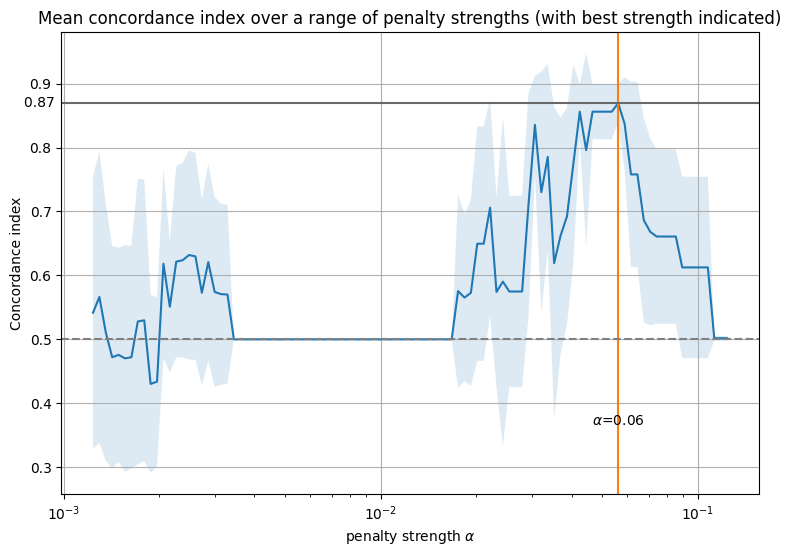

In [43]:
save_concord_idx_vs_alphas_plot()

Generating features and coefficients plot...
Number of non-zero coefficients: 6
Index(['Order_Name=$$$2178390', 'Order_Name=161', 'Order_Name=25483',
       'Order_Name=372416', 'Order_Name=884172',
       'Order_Name=dry mouth treatment'],
      dtype='object')
Order_Name=$$$2178390             0.430530
Order_Name=161                    0.212327
Order_Name=25483                 -0.024189
Order_Name=372416                -0.041159
Order_Name=884172                -0.082718
Order_Name=dry mouth treatment   -0.008964
Name: coefficient, dtype: float64
Generating features and coefficients plot done.


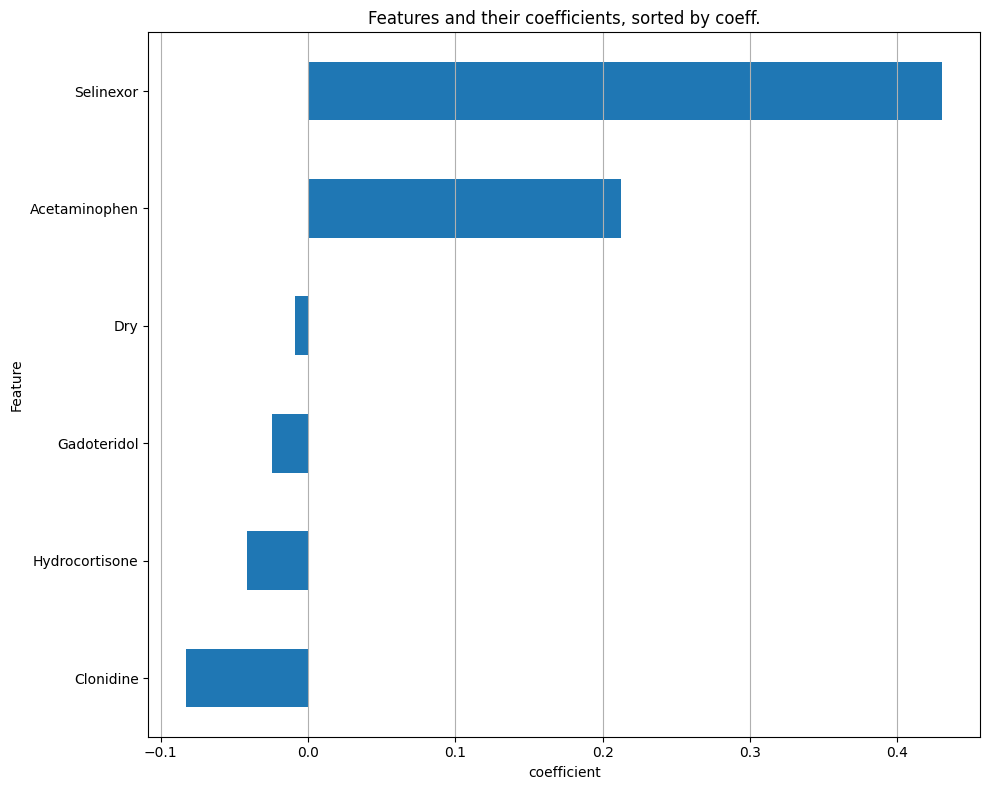

In [30]:
save_features_and_coeffs_plot()

In [38]:
save_prognosis_plot_for_specific_feature(level= "Selinexor")

Generating prognosis plot for specific feature...


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

Survival and Cumulative Hazard Function
https://scikit-survival.readthedocs.io/en/stable/user_guide/coxnet.html#Survival-and-Cumulative-Hazard-Function

NameError: name 'StandardScaler' is not defined